
# Intro

 This presents a proof of concept for a new application, pipe detection from aerial drone images.
 
 See the readme.md for more.

In [1]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32'

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


import skimage
from skimage import transform, color

from path import Path
import arrow
from tqdm import tqdm

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize']=(10,10)

In [4]:
import keras
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.
Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, cuDNN 4007)


# Load data

Our source data are split 1:2 for testing and training. These where augumented by:

- random rotations up to 360 degrees
- up to 80% horizontal and vertical translations
- zoom of 80%
- shear of up to 10 degrees
- jitter of 1% for each color channel

Then resized to 80x112 for training.

In [5]:
img_rows = 80
img_cols = 112
batch_size=10
seed=1
output_shape=(img_rows,img_cols)

In [6]:
dest_dir = Path('./data/augumented/train')
dest_dir_test = Path('./data/augumented/test')

# make sure image match
images=sorted(dest_dir.glob('image/*.png'))
masks=sorted(dest_dir.glob('mask/*.png'))
assert len(dest_dir.glob('image/*.png'))==len(dest_dir.glob('mask/*.png')), 'should be same number of pngs'
for i,[image,mask] in enumerate(zip(images,masks)):
    assert image.basename()==mask.basename(),'i=%s %s!=%s'%(i,image.basename(),mask.basename())

In [7]:
data_gen_args=dict(
                rotation_range=10.,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=np.deg2rad(10),
                zoom_range=0.1,
                channel_shift_range=0.01,
                fill_mode='constant',
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1/255.
)

datagen1 = ImageDataGenerator(**data_gen_args)
datagen2 = ImageDataGenerator(**data_gen_args)

image_gen=datagen1.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )
mask_gen=datagen2.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                 )


# join the generators (converting the mask to greyscale)
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

train_gen=dual_gen(image_gen,mask_gen)

X_train, y_train=next(train_gen)
X_train.shape, y_train.shape

Found 3870 images belonging to 1 classes.
Found 3870 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

In [8]:
# test gen
data_gen_args=dict(
                fill_mode='constant',
                rescale=1/255.
)

datagen_test1 = ImageDataGenerator(**data_gen_args)
datagen_test2 = ImageDataGenerator(**data_gen_args)

image_gen_test=datagen_test1.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )
mask_gen_test=datagen_test2.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )

# join the generators
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

test_gen=dual_gen(image_gen_test,mask_gen_test)

X_test, y_test=next(test_gen)
X_test.shape, y_test.shape

Found 503 images belonging to 1 classes.
Found 503 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

In [9]:
# train gen, but this time un-augumented so I can directly compare them for overfitting
data_gen_args=dict(
                fill_mode='constant',
                rescale=1/255.
)

datagen_test1b = ImageDataGenerator(**data_gen_args)
datagen_test2b = ImageDataGenerator(**data_gen_args)

image_gen_train2=datagen_test1b.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['image'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )
mask_gen_train2=datagen_test2b.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['mask'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )

# join the generators
def dual_gen(image_gen,mask_gen):
    for image,mask in zip(image_gen,mask_gen):
        mask=skimage.color.rgb2grey(np.transpose(mask,(0,2,3,1)))
        yield image,mask

train_gen_unaugumented=dual_gen(image_gen_train2,mask_gen_train2)

X_test, y_test=next(train_gen_unaugumented)
X_test.shape, y_test.shape

Found 3870 images belonging to 1 classes.
Found 3870 images belonging to 1 classes.


((10, 3, 80, 112), (10, 80, 112))

Note: please check the images and mask match!

If they don't you probobly have the wrong version of keras. Use: `pip install https://github.com/wassname/keras/archive/patch-1.zip`

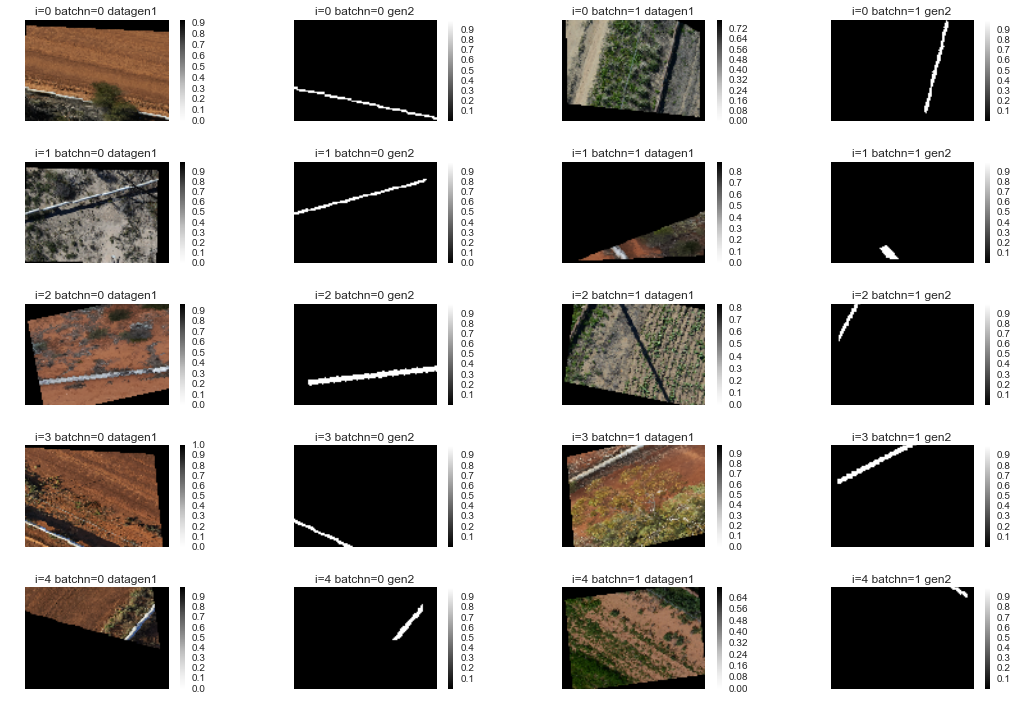

In [10]:
# View some of the data
seed=1
n=5
rows=n
cols=4

pltnb=0
plt.figure(figsize=(15,rows*2))
for i in range(n):
    X_train, y_train=next(train_gen)
    for b in range(2):
        # create a grid of 3x2
        pltnb+=1
        plt.subplot(rows,cols,pltnb)
        plt.title('i=%s batchn=%s datagen1'%(i,b))
        plt.imshow(np.transpose(X_train[b],(1,2,0)))
        plt.colorbar()
        plt.axis('off')


        pltnb+=1
        plt.subplot(rows,cols,pltnb)
        
        plt.title('i=%s batchn=%s gen2'%(i,b))
        plt.imshow(y_train[b], cmap=plt.get_cmap('gray'))
        plt.colorbar()
        plt.axis('off')
plt.tight_layout()
plt.show()

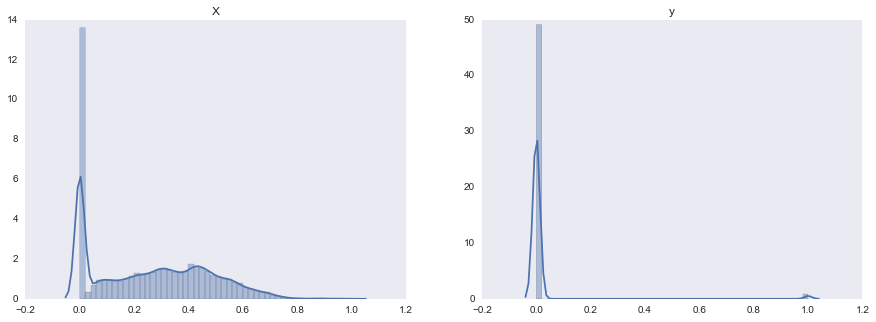

In [203]:
# show data dist
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(X_train.flatten())
plt.title('X')

plt.subplot(1,2,2)
sns.distplot(y_train.flatten())
plt.title('y')

# Metrics

We use the [Sørensen–Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) after transforming it to [0-1] and smoothing it to a ~L1 (linear) loss.

$$ L = 1-\frac{ 2 \sum_i|A_i B_i|+ \delta}{\sum_i A_i^2 + B_i^2 + \delta}$$

In [11]:
# define custom loss and metric functions 

from keras import backend as K
smooth = 1

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

# I think the missing one was a mistake, because it made loss(y_true,y_true)=-1
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# Model

![model_diagram](images/model_diagram.png)
*The model architecture. Each box is a inception module or convolution with the number of feature layers denotes in brackets. The output size is denoted below the box and the arrows denote differen't operation.*

![inception_module](images/inception_module.png)
*The inception module used in this paper, as originally proposed in [^5].*

[^5]: https://arxiv.org/pdf/1512.00567v3.pdf "Rethinking the Inception Architecture for Computer Vision"

In [12]:
import sys
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda, Reshape
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras import backend as K


def unet_inception_model(optimiser, img_cols=512, img_rows=512, activation='relu', dropout=0.5, init='he_normal', splitted=True):
    actv = activation == 'relu' and (lambda: LeakyReLU(0.1)) or activation == 'elu' and (lambda: ELU(1.0)) or None
        
    def inception_block(inputs, depth, batch_mode=0, splitted=False):
        """Inception block  v1 with asymetric convolutions"""
        assert depth % 16 == 0
        
        c1_1 = Convolution2D(int(depth/4), 1, 1, init=init, border_mode='same')(inputs)

        c2_1 = Convolution2D(int(depth/8*3), 1, 1, init=init, border_mode='same')(inputs)
        c2_1 = actv()(c2_1)
        if splitted:
            c2_2 = Convolution2D(int(depth/2), 1, 3, init=init, border_mode='same')(c2_1)
            c2_2 = BatchNormalization(mode=batch_mode, axis=1)(c2_2)
            c2_2 = actv()(c2_2)
            c2_3 = Convolution2D(int(depth/2), 3, 1, init=init, border_mode='same')(c2_2)
        else:
            c2_3 = Convolution2D(int(depth/2), 3, 3, init=init, border_mode='same')(c2_1)

        c3_1 = Convolution2D(int(depth/16), 1, 1, init=init, border_mode='same')(inputs)
        c3_1 = actv()(c3_1)
        if splitted:
            c3_2 = Convolution2D(int(depth/8), 1, 5, init=init, border_mode='same')(c3_1)
            c3_2 = BatchNormalization(mode=batch_mode, axis=1)(c3_2)
            c3_2 = actv()(c3_2)
            c3_3 = Convolution2D(int(depth/8), 5, 1, init=init, border_mode='same')(c3_2)
        else:
            c3_3 = Convolution2D(int(depth/8), 5, 5, init=init, border_mode='same')(c3_1)

        p4_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), border_mode='same')(inputs)
        c4_2 = Convolution2D(int(depth/8), 1, 1, init=init, border_mode='same')(p4_1)

        res = merge([c1_1, c2_3, c3_3, c4_2], mode='concat', concat_axis=1)
        res = BatchNormalization(mode=batch_mode, axis=1)(res)
        res = actv()(res)
        return res


    def residual_skip(inputs, num, depth, scale=0.1):
        """
        A skip connection with a branch to a residual block

               / 1x1conv \
        input ---------- - output
        """
        residual = Convolution2D(depth, num, num, border_mode='same')(inputs)
        residual = BatchNormalization(mode=2, axis=1)(residual)
        residual = Lambda(lambda x: x*scale)(residual)
        res = merge([inputs, residual], mode="sum")
        return actv()(res)


    def reduction_block(nb_filter, nb_row, nb_col, border_mode='same', subsample=(1, 1)):
        """Downsampling using a strided convolution followed by batchnorm and activation"""
        def f(_input):
            conv = Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample,
                                  border_mode=border_mode)(_input)
            norm = BatchNormalization(mode=2, axis=1)(conv)
            return actv()(norm)

        return f

    def get_unet_inception_2head(optimizer):

        inputs = Input((3, img_rows, img_cols), name='main_input')
        conv1 = inception_block(inputs, 32, batch_mode=2, splitted=splitted)

        pool1 = reduction_block(32, 3, 3, border_mode='same', subsample=(2,2))(conv1)
        pool1 = Dropout(dropout)(pool1)

        conv2 = inception_block(pool1, 64, batch_mode=2, splitted=splitted)
        pool2 = reduction_block(64, 3, 3, border_mode='same', subsample=(2,2))(conv2)
        pool2 = Dropout(dropout)(pool2)

        conv3 = inception_block(pool2, 128, batch_mode=2, splitted=splitted)
        pool3 = reduction_block(128, 3, 3, border_mode='same', subsample=(2,2))(conv3)
        pool3 = Dropout(dropout)(pool3)

        conv4 = inception_block(pool3, 256, batch_mode=2, splitted=splitted)
        pool4 = reduction_block(256, 3, 3, border_mode='same', subsample=(2,2))(conv4)
        pool4 = Dropout(dropout)(pool4)

        conv5 = inception_block(pool4, 512, batch_mode=2, splitted=splitted)
        conv5 = Dropout(dropout)(conv5)

        after_conv4 = residual_skip(conv4, 1, 256)
        up6 = merge([UpSampling2D(size=(2, 2))(conv5), after_conv4], mode='concat', concat_axis=1)
        conv6 = inception_block(up6, 256, batch_mode=2, splitted=splitted)
        conv6 = Dropout(dropout)(conv6)

        after_conv3 = residual_skip(conv3, 1, 128)
        up7 = merge([UpSampling2D(size=(2, 2))(conv6), after_conv3], mode='concat', concat_axis=1)
        conv7 = inception_block(up7, 128, batch_mode=2, splitted=splitted)
        conv7 = Dropout(dropout)(conv7)

        after_conv2 = residual_skip(conv2, 1, 64)
        up8 = merge([UpSampling2D(size=(2, 2))(conv7), after_conv2], mode='concat', concat_axis=1)
        conv8 = inception_block(up8, 64, batch_mode=2, splitted=splitted)
        conv8 = Dropout(dropout)(conv8)

        after_conv1 = residual_skip(conv1, 1, 32)
        up9 = merge([UpSampling2D(size=(2, 2))(conv8), after_conv1], mode='concat', concat_axis=1)
        conv9 = inception_block(up9, 32, batch_mode=2, splitted=splitted)
        conv9 = Dropout(dropout)(conv9)

        conv10 = Convolution2D(1, 1, 1, init=init, activation='hard_sigmoid')(conv9)
        reshp = Reshape((img_rows,img_cols), name='main_output')(conv10)

        model = Model(input=inputs, output=reshp)
        model.compile(optimizer=optimizer,
                      loss=[dice_coef_loss],
                      metrics=['accuracy']
                     )

        return model

    return get_unet_inception_2head(optimiser)


# Train

## Training

In [13]:
model_name='unet_inception_inv2'
optimizer = keras.optimizers.Nadam(lr=2e-4)
model = unet_inception_model(optimizer,img_cols,img_rows,dropout=0.5)
model_checkpoint = ModelCheckpoint('models/%s_weights.hdf5'%model_name, monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=2, monitor='val_acc')

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 3, 80, 112)    0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 12, 80, 112)   48          main_input[0][0]                 
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 2, 80, 112)    8           main_input[0][0]                 
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 12, 80, 112)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [15]:
# load pre-trained model?
# model.load_weights('models/unet_inception_inv2_20160929-10-50-26_acc-0.75_weights.hdf5')

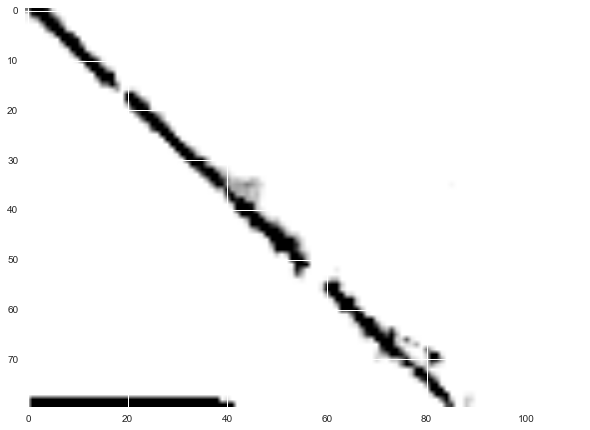

In [16]:
# sanity test
# y_pred = model.predict(X_test)
# plt.imshow(y_pred[0]>0.5)

In [ ]:
model_checkpoint = ModelCheckpoint('models/%s_weights.hdf5'%model_name, monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=2, monitor='val_acc')

history3 = model.fit_generator(train_gen, 
                               samples_per_epoch=400, 
                               nb_epoch=200, 
                               verbose=1, 
                               validation_data=test_gen,
                               nb_val_samples=170,
                               callbacks=[
                                          model_checkpoint,
#                                          early_stopping
                                         ])

Epoch 1/200
400/400 [==============================] - 64s - loss: 0.8976 - acc: 0.0242 - val_loss: 0.8691 - val_acc: 0.0461
Epoch 2/200
400/400 [==============================] - 48s - loss: 0.8535 - acc: 0.0391 - val_loss: 0.7940 - val_acc: 0.0903
Epoch 3/200
400/400 [==============================] - 47s - loss: 0.8137 - acc: 0.0565 - val_loss: 0.6822 - val_acc: 0.1158
Epoch 4/200
400/400 [==============================] - 48s - loss: 0.7147 - acc: 0.0676 - val_loss: 0.6004 - val_acc: 0.2094
Epoch 5/200
400/400 [==============================] - 50s - loss: 0.6409 - acc: 0.0751 - val_loss: 0.5747 - val_acc: 0.2436
Epoch 6/200
400/400 [==============================] - 46s - loss: 0.5866 - acc: 0.0832 - val_loss: 0.5002 - val_acc: 0.3364
Epoch 7/200
400/400 [==============================] - 47s - loss: 0.5425 - acc: 0.0929 - val_loss: 0.4716 - val_acc: 0.3748
Epoch 8/200
400/400 [==============================] - 47s - loss: 0.5224 - acc: 0.0998 - val_loss: 0.4599 - val_acc: 0.3287


In [17]:
%%time
score = model.evaluate_generator(test_gen, val_samples=350)
score=dict(zip(model.metrics_names,score))
print(score)

{'acc': 0.7344642894608634, 'loss': 0.10256582477263042}
CPU times: user 35 s, sys: 2.7 s, total: 37.7 s
Wall time: 34.7 s


In [134]:
wfn='models/{}_{}_acc-{:2.2f}_weights.hdf5'.format(model_name,ts,score['acc'])
model.save_weights(wfn)
wfn

'models/unet_inception_inv2_20160929-10-50-26_acc-0.75_weights.hdf5'

Note that the difference in accuracy curves below is because we augumented the training data and so "acc" is lower. On the other hand the validation/test data was unaugumented, giving a higher accuracy.

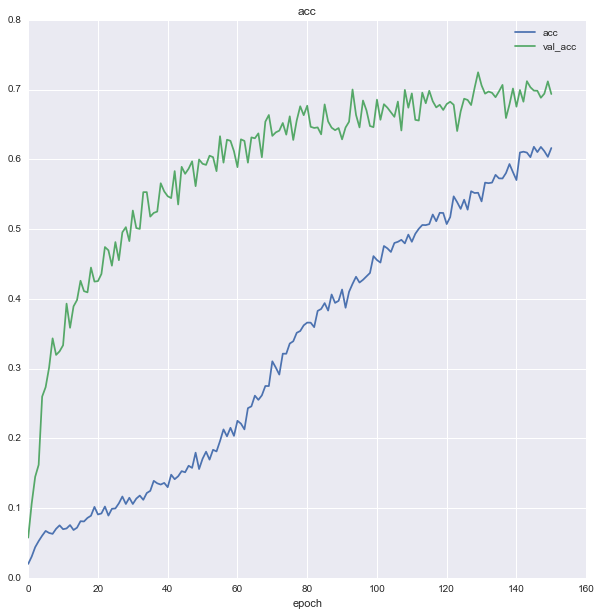

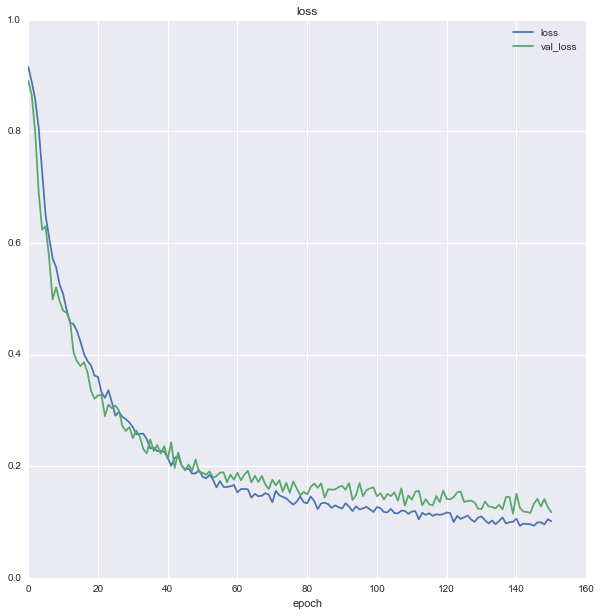

In [95]:
def plot_hist(history):
    """plot keras history object"""
    for label in history.history:
        if not label.startswith('val'):
            plt.title(label)
            plt.plot(history.history[label], label=label)
            if 'val_' + label in history.history:
                plt.plot(history.history['val_' + label], label=label)
            plt.xlabel('epoch')
            plt.show()

plot_hist(model.history)

## Results

Note we compare the unugumented training and unugumented testing data to see if it overfits. If we compared the augumented and unaugumented we would get strange results like more accuracy on the validation data than the test data, but this is due to artificially increased variance on the augumented training data.

In [44]:
model = unet_inception_model(optimizer,img_cols,img_rows)

# load best checkpoint
# model.load_weights('models/%s_weights.hdf5'%model_name)

# or load pre-trained model
model.load_weights('models/unet_inception_inv2_20160929-10-50-26_acc-0.75_weights.hdf5')
val_samples=10000

# add a few other metrics
model.compile(optimizer=optimizer,
              loss=[dice_coef_loss],
              metrics=[
                'accuracy',
                'mse',
                'binary_crossentropy',
                'matthews_correlation',
                'binary_accuracy',
                ]
             )

In [45]:
%%time
score = model.evaluate_generator(test_gen, val_samples=val_samples)
score=dict(zip(model.metrics_names,score))
print(score)

{'mean_squared_error': 0.0078170919320546088, 'matthews_correlation': 0.77096645796298979, 'loss': 0.1007234075255692, 'acc': 0.73327500212192531, 'binary_crossentropy': 0.08795671812444926, 'binary_accuracy': 0.99096557062864299}
CPU times: user 3min 57s, sys: 1min 3s, total: 5min 1s
Wall time: 3min 52s


In [48]:
%%time
score = model.evaluate_generator(train_gen_unaugumented, val_samples=val_samples)
score=dict(zip(model.metrics_names,score))
print(score)

{'mean_squared_error': 0.0075589731866493818, 'matthews_correlation': 0.81601719522476202, 'loss': 0.079188272582367061, 'acc': 0.73974999982118606, 'binary_crossentropy': 0.083371352989226585, 'binary_accuracy': 0.99112304443120958}
CPU times: user 3min 27s, sys: 1min 3s, total: 4min 30s
Wall time: 3min 23s


In [50]:
%%time
score = model.evaluate_generator(train_gen, val_samples=val_samples)
score=dict(zip(model.metrics_names,score))
print(score)

{'mean_squared_error': 0.0069730838667601347, 'matthews_correlation': 0.8103281590938568, 'loss': 0.074400506030768157, 'acc': 0.7660037497878075, 'binary_crossentropy': 0.075926830759271979, 'binary_accuracy': 0.15817984386076386}
CPU times: user 3min 28s, sys: 1min 2s, total: 4min 31s
Wall time: 3min 22s


In [25]:
X_test, y_test = next(test_gen)
y_pred = model.predict(X_test)

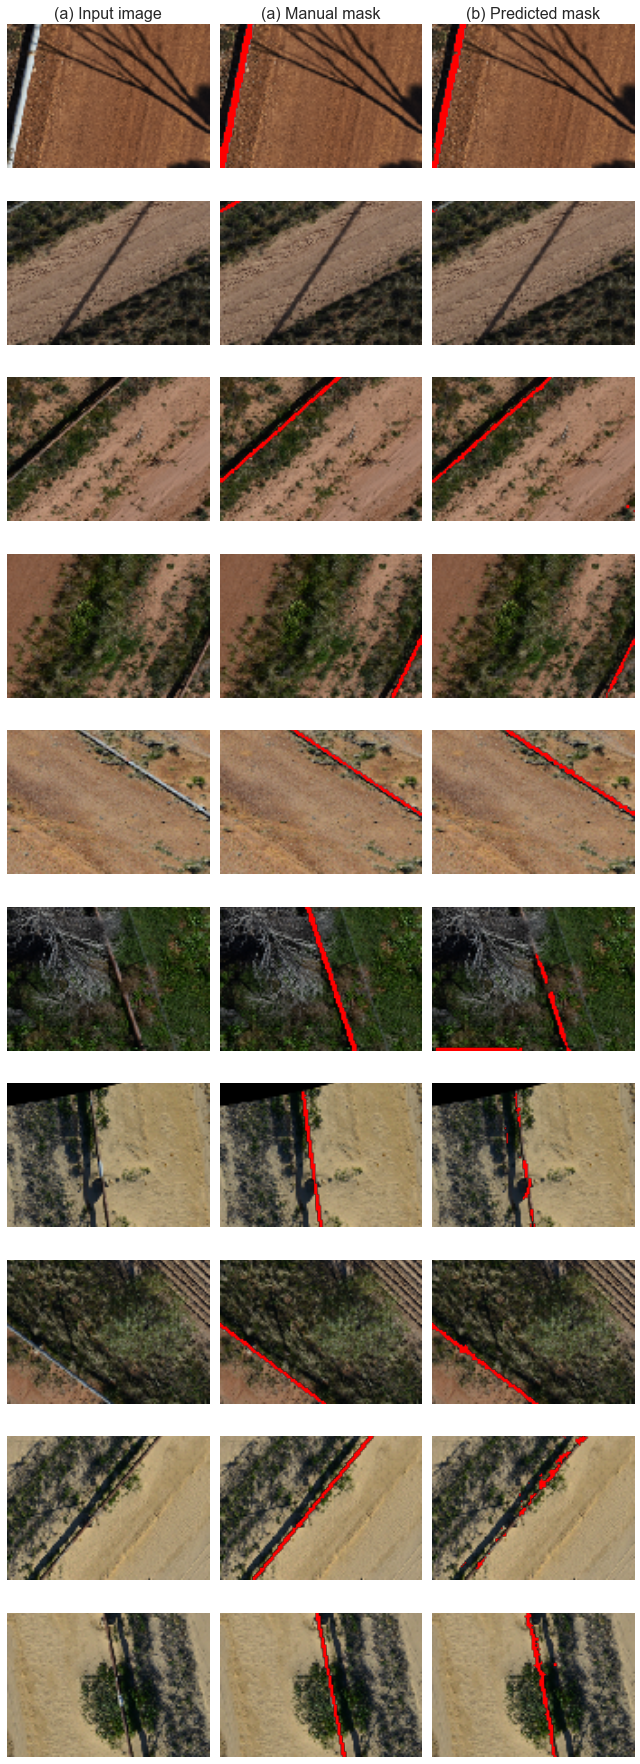

In [26]:
from matplotlib.colors import LogNorm
norm=LogNorm(vmin=1e-3, vmax=1.0)
sns.set_style("dark")
n=batch_size
plt.figure(figsize=(9,2.5*n))


fontsize=16
for i in range(n):
    
    ax=plt.subplot(n,3,1+i*3)
    if i==0: plt.title('(a) Input image', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax=plt.subplot(n,3,2+i*3)
    if i==0: plt.title('(a) Manual mask', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    cm=plt.imshow(y_test[i]>0.5, norm=norm, alpha=1, cmap=plt.cm.rainbow)
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax=plt.subplot(n,3,3+i*3)
    if i==0: plt.title('(b) Predicted mask', fontsize=fontsize)
    plt.imshow(np.transpose(X_test,(0,2,3,1))[i])
    cm=plt.imshow(y_pred[i]>0.5, norm=norm, alpha=1, cmap=plt.cm.rainbow)
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()
